In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
import os
import sweetviz as sv
from IPython.display import IFrame
import time
import requests
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier

/home/kali/anaconda3/envs/mlbot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Binanceのインスタンスを作成（レートリミットを有効化）
exchange = ccxt.binance({
    'enableRateLimit': True,
})

# BTC/USDTのデータを取得
symbol = 'BTC/USDT'
timeframe = '1h'  # 15分足のデータ
since = exchange.parse8601('2020-01-01T00:00:00Z')  # データの開始日

# データを取得する関数（例外処理と進行状況の追加）
def fetch_all_ohlcv(symbol, timeframe, since):
    all_ohlcv = []
    now = exchange.milliseconds()
    while since < now:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit=1000)
            if not ohlcv:
                break
            since = ohlcv[-1][0] + 1  # タイムスタンプを更新
            all_ohlcv.extend(ohlcv)
        except Exception as e:
            print(f'An error occurred: {e}')
            # リトライのために一時停止
            time.sleep(5)
            continue
    return all_ohlcv

# データを取得
ohlcv = fetch_all_ohlcv(symbol, timeframe, since)
data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# タイムスタンプを変換
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

# CSVファイルとして保存
data.to_csv('btc_usdt_1h_2018_to_now.csv', index=False)

print('Data fetching and saving completed.')

Data fetching and saving completed.


In [3]:
# データの読み込みと文字列として保存されている日時情報を日時型のデータに変換
df = pd.read_csv('btc_usdt_1h_2018_to_now.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
# タイムスタンプでソートとインデックスのリセット
df.sort_values('timestamp', inplace=True)#inplaceで新しいdataframeを作成せず元のを変更
# 列をインデックス（行ラベル）として設定
df.set_index('timestamp', inplace=True)

<Axes: xlabel='timestamp'>

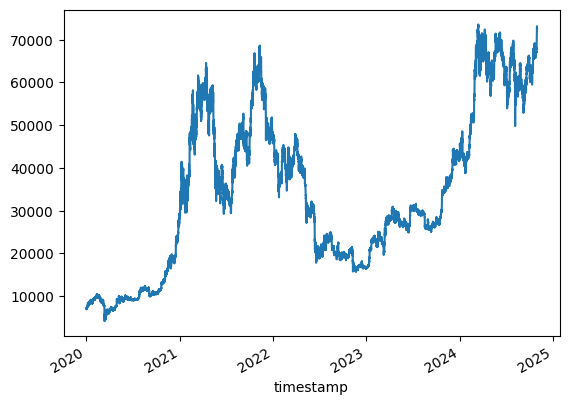

In [5]:
df['close'].plot()

In [6]:
# 特徴量エンジニアリング
# 移動平均線の計算
df['SMA_10'] = df['close'].rolling(window=10).mean()
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_30'] = df['close'].rolling(window=30).mean()
df['SMA_100'] = df['close'].rolling(window=100).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()

# 指数移動平均線の計算
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA_200'] = df['close'].ewm(span=200, adjust=False).mean()

# RSIの計算
def compute_RSI(data, time_window):
    diff = data.diff(1) #1つ前の行との違い
    up_chg = diff.clip(lower=0) #差分が負の物は0に変換
    down_chg = -diff.clip(upper=0) #差分が0より大きいものを全て0に置き換える
    up_chg_avg = up_chg.ewm(com=time_window - 1, min_periods=time_window).mean() #価格が上昇した指数移動平均
    down_chg_avg = down_chg.ewm(com=time_window - 1, min_periods=time_window).mean()
    rs = up_chg_avg / down_chg_avg #上昇した強さと下落した強さの比率
    rsi = 100 - 100 / (1 + rs) 
    return rsi

df['RSI_14'] = compute_RSI(df['close'], 14)

# MACDの計算
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# ボリンジャーバンドの計算
df['STD_20'] = df['close'].rolling(window=20).std() #stdは標準偏差(データのばらつき度合い)を計算
df['Upper_Band'] = df['SMA_20'] + (df['STD_20'] * 2)
df['Lower_Band'] = df['SMA_20'] - (df['STD_20'] * 2)

# 遅延特徴量の作成
for lag in range(1, 6): #shift(lag) は、df['close'] のデータを lag 分だけ下にシフト
    df[f'lag_{lag}'] = df['close'].shift(lag) #lag_1からlag_5 までの5つの遅延列が作成

# 時間に関する特徴量
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek #曜日は0から6の値で表される

#ATR（平均真の範囲、Average True Range）
df['TR'] = df['high'] - df['low']
df['ATR_14'] = df['TR'].rolling(window=14).mean()

#ADX（平均方向性指数、Average Directional Index）
def compute_ADX(data, period=14):
    high = data['high']
    low = data['low']
    close = data['close']
    
    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr = high.combine(low, max) - low.combine(close.shift(), min)

    atr = tr.rolling(window=period).mean()

    plus_di = 100 * (plus_dm.ewm(alpha=1/period).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/period).mean() / atr))
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period).mean()
    
    return adx

df['ADX_14'] = compute_ADX(df)

#CCI（商品チャンネル指数、Commodity Channel Index）
df['TP'] = (df['high'] + df['low'] + df['close']) / 3
df['CCI_14'] = (df['TP'] - df['TP'].rolling(window=14).mean()) / (0.015 * df['TP'].rolling(window=14).std())

#OBV（オンバランスボリューム、On-Balance Volume）
df['OBV'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()

#Stochastic Oscillator（ストキャスティクス）
df['L14'] = df['low'].rolling(window=14).min()
df['H14'] = df['high'].rolling(window=14).max()
df['%K'] = 100 * (df['close'] - df['L14']) / (df['H14'] - df['L14'])
df['%D'] = df['%K'].rolling(window=3).mean()



In [7]:
# 目標変数の作成
df['return'] = df['close'].pct_change().shift(-1) #前の行とのパーセンテージの変化
df['target'] = (df['return'] > 0).astype(int) #価格が上昇したらTrue

In [8]:
# 欠損値の削除
df.dropna(inplace=True)

In [9]:
# 特徴量と目標変数の定義
features = ['open', 'high', 'low', 'close', 'volume', 'SMA_10', 'SMA_30','SMA_100', 'SMA_200',
            'EMA_20',  'EMA_200', 'RSI_14', 'MACD', 'Signal_Line',
            'Upper_Band', 'Lower_Band', 'ATR_14', 'ADX_14', 'CCI_14', 'OBV', '%K', '%D', 'hour', 'day_of_week'] + [f'lag_{lag}' for lag in range(1,6)]

X = df[features]
y = df['target'] #価格が上昇すれば1下落すれば0

In [10]:
# データの分割（時間ベースでの分割）
split_date = '2024-01-01'
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

In [12]:
# ランダムフォレストモデルのインスタンス化
rf_model = RandomForestClassifier(
    n_estimators=100,       # 使用する決定木の数
    max_depth=10,           # 各木の深さ
    random_state=42         # 再現性のためのランダムシード
)

# モデルの学習
rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, random_state=42)

Accuracy: 0.5216494845360825

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.58      0.54      3575
           1       0.53      0.47      0.50      3700

    accuracy                           0.52      7275
   macro avg       0.52      0.52      0.52      7275
weighted avg       0.52      0.52      0.52      7275



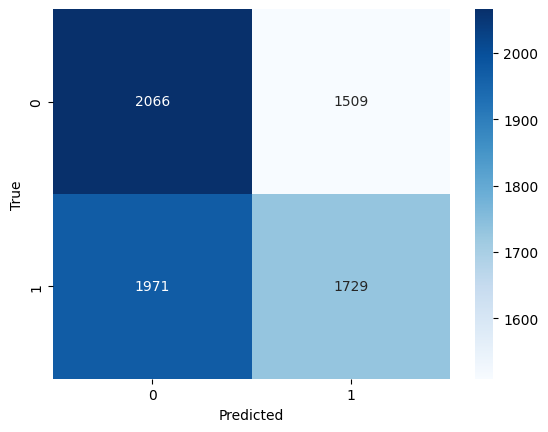

In [15]:
# 予測
y_pred = model.predict(X_test)

# y_testと同じインデックスをy_predに設定
y_pred = pd.Series(y_pred, index=y_test.index)

# 精度と評価指標の表示
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Final capital: 5609.664375161522
Sharpe Ratio: 2.521484896197789


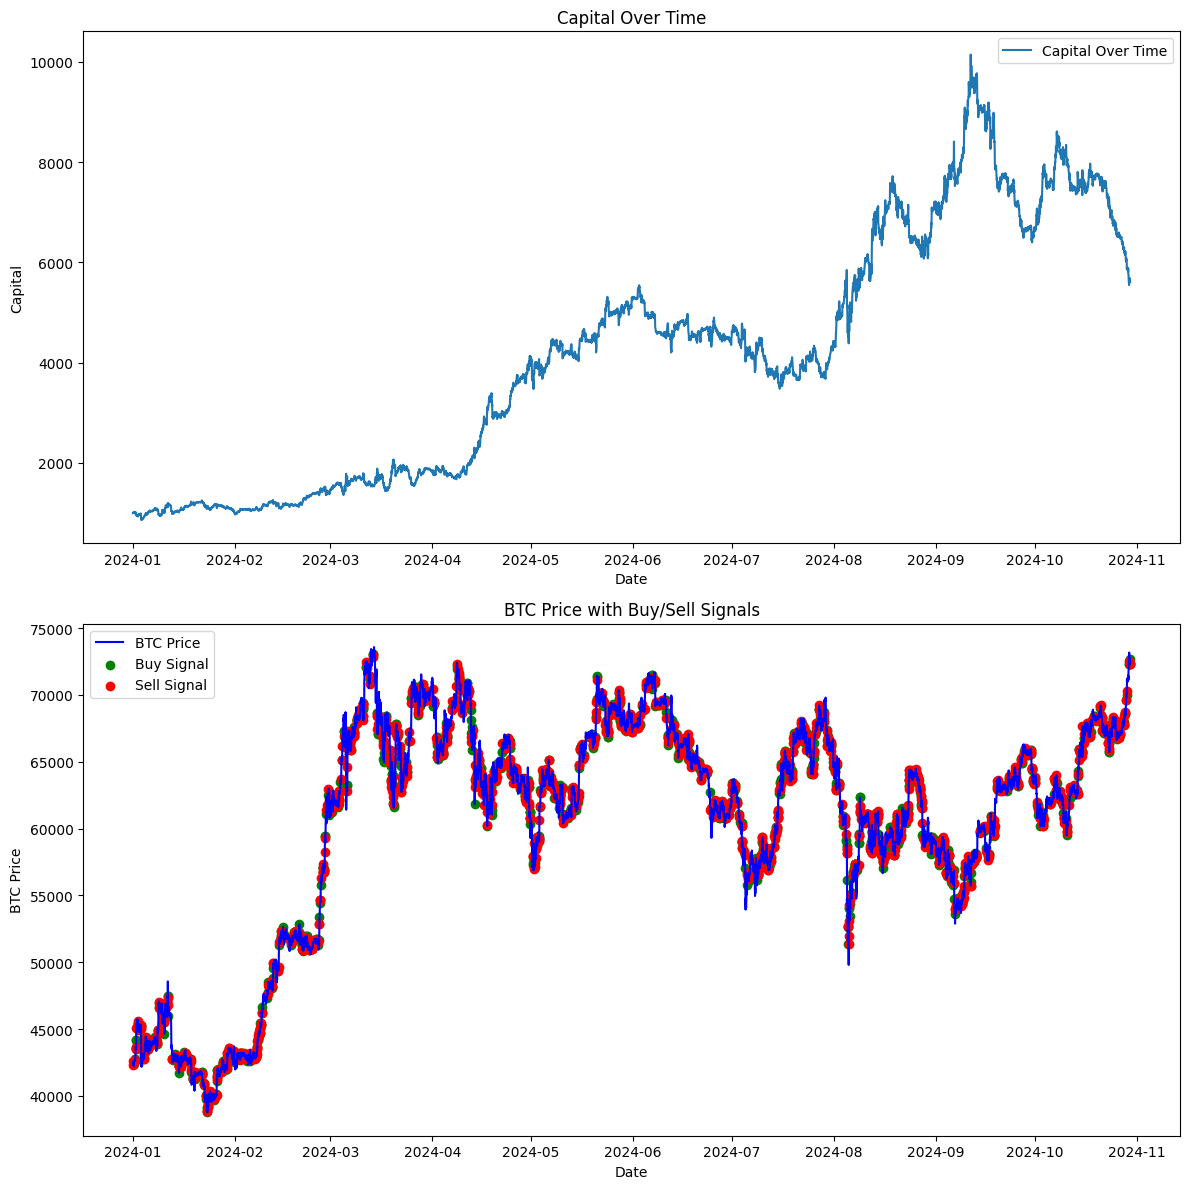

In [16]:
# 初期設定
initial_capital = 1000
capital = initial_capital  # 初期資金をリセット
capital_history = []
positions = []
buy_signals = []
sell_signals = []

leverage = 2  # レバレッジ

# 現在のポジションの状態を示す変数
current_position = 0  # 1=ロング, -1=ショート, 0=ポジションなし

# テスト期間の日付リスト
test_dates = X_test.index

for i in range(len(test_dates) - 1):
    date = test_dates[i]
    prediction = y_pred[i]
    close_price = df.loc[date, 'close']
    next_date = test_dates[i + 1]
    next_close_price = df.loc[next_date, 'close']
    
    # ポジションの決定と変更
    if prediction == 1:  # 上がると予想
        if current_position == -1:  # 現在ショートなら決済してロングに変更
            sell_signals.append((date, close_price))  # ショート決済
            current_position = 1
            buy_signals.append((next_date, next_close_price))  # ロングエントリー

        elif current_position == 0:
            current_position = 1
            buy_signals.append((next_date, next_close_price))  # ロングエントリー

        else:
            current_position = 1
        

    elif prediction == 0:  # 下がると予想
        if current_position == 1:  # 現在ロングなら決済してショートに変更
            buy_signals.append((date, close_price))  # ロング決済
            current_position = -1
            sell_signals.append((next_date, next_close_price))  # ショートエントリー

        elif current_position == 0:
            current_position = -1
            sell_signals.append((next_date, next_close_price))  # ショートエントリー

        else:
            current_position = -1

    # リターンの計算
    ret = (next_close_price - close_price) / close_price * current_position * leverage
    capital = capital * (1 + ret)
    capital_history.append(capital)
    positions.append(current_position)

# バックテスト結果のデータフレーム作成
backtest_results = pd.DataFrame(index=test_dates[:-1])
backtest_results['Capital'] = capital_history
backtest_results['Position'] = positions

# リターンの計算
backtest_results['Return'] = backtest_results['Capital'].pct_change().fillna(0)

# シャープレシオの計算（リスクフリーレートは0と仮定）
sharpe_ratio = (backtest_results['Return'].mean() / backtest_results['Return'].std()) * np.sqrt(365 * 24)

print('Final capital:', capital)
print('Sharpe Ratio:', sharpe_ratio)

# 資産推移と売買のプロット
plt.figure(figsize=(12, 12))

# 1つ目のグラフ: 資産推移のプロット
plt.subplot(2, 1, 1)
plt.plot(backtest_results.index, backtest_results['Capital'], label='Capital Over Time')
plt.title('Capital Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()

# 2つ目のグラフ: BTC価格と売買シグナルのプロット
plt.subplot(2, 1, 2)
plt.plot(df.loc[test_dates[:-1], 'close'], label='BTC Price', color='blue')

# 買いのシグナル（緑の丸）
if buy_signals:
    buy_dates, buy_prices = zip(*buy_signals)
    plt.scatter(buy_dates, buy_prices, color='green', label='Buy Signal', marker='o')

# 売りのシグナル（赤の丸）
if sell_signals:
    sell_dates, sell_prices = zip(*sell_signals)
    plt.scatter(sell_dates, sell_prices, color='red', label='Sell Signal', marker='o')

plt.title('BTC Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()

plt.tight_layout()
plt.show()
